# **PASSO 1 — Preparar o Ambiente**

Neste passo, importamos as bibliotecas necessárias e verificamos se o TensorFlow está configurado corretamente.
Também checamos se há GPU disponível, o que acelera o treinamento do modelo.


---



In [ ]:
# PASSO 1 — Preparar o Ambiente
# Neste passo importamos as bibliotecas principais do projeto
# e verificamos se o TensorFlow está funcionando corretamente.

# Importa o TensorFlow, principal biblioteca usada para redes neurais
import tensorflow as tf

# Importa o TensorFlow Datasets (TFDS), que usaremos para carregar o dataset Cats vs Dogs
import tensorflow_datasets as tfds

# Numpy será usado para manipular arrays e previsões
import numpy as np

# Matplotlib será usado para criar gráficos de treino e validação
import matplotlib.pyplot as plt

# Exibe a versão atual do TensorFlow instalada no Google Colab
print("TensorFlow versão:", tf.__version__)

# Verifica se existe uma GPU disponível para acelerar o treinamento
# Se aparecer algo como 'GPU available: True', o treinamento será bem mais rápido
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPU disponível:", gpu_devices)


TensorFlow versão: 2.19.0
GPU disponível: []


# **PASSO 2 — Carregar o Dataset Cats vs Dogs (TFDS)**
Neste passo carregamos automaticamente o dataset Cats vs Dogs utilizando o TensorFlow Datasets (TFDS).
Dividimos o conjunto de dados em 80% para treino e 20% para validação. Cada item do dataset já vem rotulado como gato (0) ou cachorro (1).


---



In [ ]:
# PASSO 2 — Carregar o Dataset Cats vs Dogs utilizando TFDS

# Carregamos o dataset do TensorFlow Datasets.
# O parâmetro "as_supervised=True" garante que cada item vem no formato (imagem, label).
# Os splits dividem o dataset em 80% treino e 20% validação.

(ds_train, ds_val), ds_info = tfds.load(
    "cats_vs_dogs",              # nome do dataset
    split=["train[:80%]",        # primeira parte para treino
           "train[80%:]"],       # segunda parte para validação
    as_supervised=True,          # retorna (imagem, label)
    with_info=True               # retorna informações extras, como número total de imagens
)

# Exibe mensagem de confirmação
print("Dataset carregado com sucesso!")

# Mostra o total aproximado de imagens em cada subconjunto
print("Número de imagens de treino:", len(list(ds_train)))
print("Número de imagens de validação:", len(list(ds_val)))

# Exibe detalhes extras do dataset
print("\nInformações gerais do dataset:")
print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.MDCJYH_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset carregado com sucesso!
Número de imagens de treino: 18610
Número de imagens de validação: 4652

Informações gerais do dataset:
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondetermi

# **PASSO 3 — Pré-processamento das Imagens**

O objetivo deste passo é preparar as imagens para o modelo.
Redimensionamos todas para 224×224 pixels (padrão da MobileNetV2), normalizamos os valores de pixel e organizamos os dados em batches para treino e validação.



In [ ]:
# PASSO 3 — Pré-processamento das Imagens

# Definimos o tamanho da imagem que a MobileNetV2 espera como entrada.
IMG_SIZE = 224

# Função de pré-processamento aplicada a cada imagem do dataset.
def preprocess(img, label):
    # Redimensiona a imagem para 224x224 pixels.
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normaliza os valores dos pixels para a faixa [0, 1].
    # Isso ajuda o modelo a treinar de forma mais estável.
    img = img / 255.0

    return img, label

# Aplicamos o pré-processamento no dataset de treino e validação.
# - shuffle embaralha os dados para evitar padrões indesejados.
# - batch agrupa as imagens em lotes de 32.
# - prefetch permite que o próximo lote seja preparado enquanto o atual é processado.
train_ds = ds_train.map(preprocess).shuffle(1000).batch(32).prefetch(1)
val_ds = ds_val.map(preprocess).batch(32).prefetch(1)

print("Pré-processamento concluído!")


Pré-processamento concluído!


# **PASSO 4 — Construção do Modelo com Transfer Learning**

Neste passo carregamos a MobileNetV2 pré-treinada no ImageNet e congelamos suas camadas.
Em seguida adicionamos nossa própria camada final, responsável por classificar entre gato e cachorro.
Essa técnica permite aproveitar o conhecimento prévio da rede, acelerando e melhorando o treinamento.



In [ ]:
# PASSO 4 — Construção do Modelo com Transfer Learning

# Carregamos a MobileNetV2 sem a parte final (include_top=False)
# para podermos adicionar nossa própria camada de classificação.
# Os pesos carregados são do ImageNet, um dataset enorme com milhões de imagens.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # tamanho esperado da imagem
    include_top=False,                     # remove as camadas finais originais
    weights='imagenet'                     # usa pesos pré-treinados
)

# Congelamos todas as camadas da MobileNetV2.
# Assim, apenas nossa camada final será treinada.
base_model.trainable = False

# Criamos o nosso modelo completo.
model = tf.keras.Sequential([
    base_model,                                  # base pré-treinada
    tf.keras.layers.GlobalAveragePooling2D(),    # reduz a dimensionalidade
    tf.keras.layers.Dense(1, activation='sigmoid')  # camada final binária
])

# Compilamos o modelo.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Mostra um resumo completo do modelo criado.
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **PASSO 5 — Treinamento do Modelo**

Aqui realizamos o treinamento do modelo por algumas épocas.
Durante esse processo, a rede ajusta seus pesos para aprender a distinguir gatos e cachorros com base no dataset fornecido.


In [ ]:
# PASSO 5 — Treinamento do Modelo

# Aqui treinamos o modelo usando o dataset já pré-processado.
# Apenas a última camada (Dense) é ajustada durante as épocas.

history = model.fit(
    train_ds,               # dataset de treino
    validation_data=val_ds, # dataset de validação
    epochs=5                # número de passagens sobre os dados
)

print("Treinamento concluído!")


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - accuracy: 0.9613 - loss: 0.1212 - val_accuracy: 0.9822 - val_loss: 0.0502
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - accuracy: 0.9842 - loss: 0.0471 - val_accuracy: 0.9854 - val_loss: 0.0409
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.9849 - loss: 0.0407 - val_accuracy: 0.9852 - val_loss: 0.0404
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 941s 2s/step - accuracy: 0.9867 - loss: 0.0372 - val_accuracy: 0.9852 - val_loss: 0.0438
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step - accuracy: 0.9870 - loss: 0.0357 - val_accuracy: 0.9856 - val_loss: 0.0414
Treinamento concluído!


# **PASSO 6 — Visualização dos Gráficos de Treino**

Este passo serve para avaliar visualmente o desempenho do modelo.
Plotamos as curvas de accuracy e loss para verificar se há overfitting ou underfitting e entender como o modelo evoluiu a cada época.



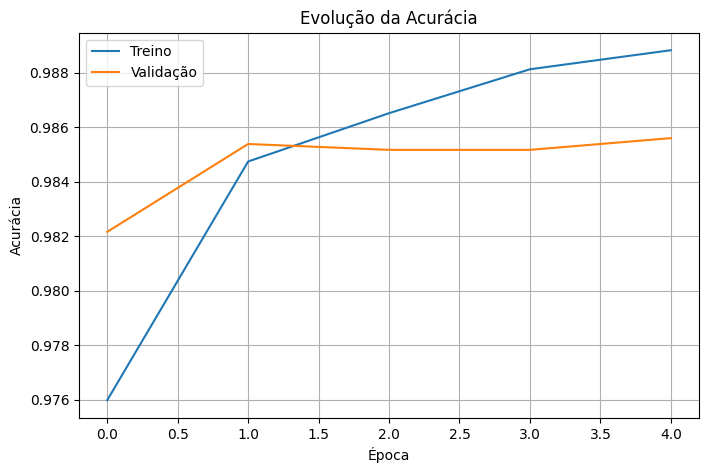

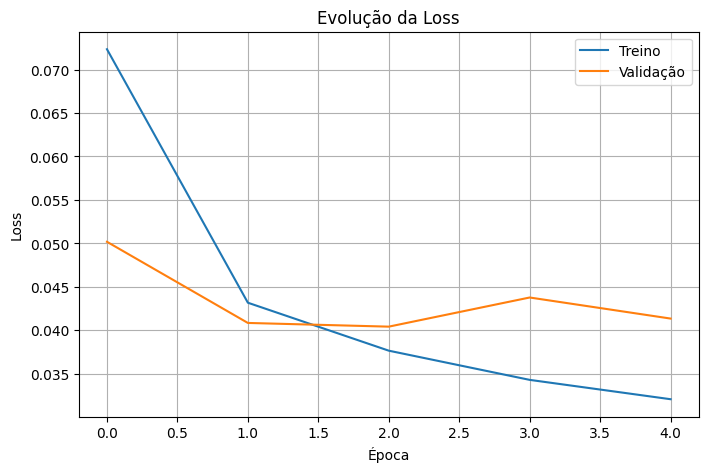

In [ ]:
# PASSO 6 — Gráficos de Treinamento

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# **PASSO 7 — Teste com Imagem Externa**

Agora testamos o modelo com uma imagem escolhida pelo usuário.
Esse passo demonstra a capacidade prática do modelo de classificar uma imagem real que não fez parte do treinamento.


Saving close-vertical-de-um-lindo-gato-europeu-de-pelo-curto.jpg to close-vertical-de-um-lindo-gato-europeu-de-pelo-curto (1).jpg


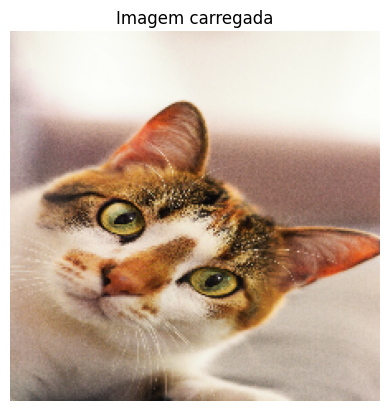

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Resultado: 🐱 GATO — confiança: 99.98%


In [ ]:
# PASSO 7 — Teste com Imagem Externa

from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Envia imagem do computador
uploaded = files.upload()

# Pega o nome do arquivo enviado
filename = list(uploaded.keys())[0]

# Carrega a imagem e redimensiona para o mesmo tamanho usado no treinamento
img = image.load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))

# Mostra a imagem enviada
plt.imshow(img)
plt.axis('off')
plt.title("Imagem carregada")
plt.show()

# Converte para array numérico
img_array = image.img_to_array(img) / 255.0   # normaliza
img_array = np.expand_dims(img_array, axis=0) # cria batch (1, H, W, 3)

# Faz a previsão
pred = model.predict(img_array)[0][0]

# Interpretação da saída
if pred < 0.5:
    classe = "🐱 GATO"
    confianca = (1 - pred) * 100
else:
    classe = "🐶 CACHORRO"
    confianca = pred * 100


print(f"Resultado: {classe} — confiança: {confianca:.2f}%")


# **PASSO 8 — Salvando o Modelo Treinado**

Neste passo salvamos o modelo final em formato .h5.
Esse arquivo pode ser reutilizado futuramente para novas predições ou para implantação em aplicações reais.



In [ ]:
# PASSO 8 — Salvando o Modelo Treinado

# Salvamos o modelo completo em formato HDF5 (.h5)
model.save("modelo_gatos_cachorros.h5")

print("Modelo salvo com sucesso como 'modelo_gatos_cachorros.h5'")


Modelo salvo com sucesso como 'modelo_gatos_cachorros.h5'
